In [2]:

import os, sys
import pandas as pd

from iwateruse.featurize import MultiOneHotEncoder
import matplotlib.pyplot as plt
from xgboost import plot_importance
import xgboost as xgb
import category_encoders as ce 
from lightgbm import LGBMRegressor

#
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib widget
%matplotlib inline
%matplotlib ipympl
import warnings

warnings.filterwarnings('ignore')
xgb.set_config(verbosity=0)


C:\Miniconda3\envs\py39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Miniconda3\envs\py39\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
# load data
dataset = pd.read_csv(r"C:\work\water_use\ml_experiments\annual_v_0_0\clean_train_db.csv")
monthly_wu = pd.read_csv(r"C:\work\water_use\CAWSC_WaterUse\etc\monthly_wu.csv")
monthly_climate = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\features\monthly_climate.csv")
monthly_wu = monthly_wu[monthly_wu['inWSA']>0]
master_pop = pd.read_csv(r"master_population.csv")
master_pop.rename(columns = {'WSA_AGIDF':'sys_id'}, inplace = True)

master_pop = master_pop[['sys_id', 'pop', 'Year']]




In [4]:
monthly_wu

,WSA_AGIDF,YEAR,Month,monthly_wu_G_swuds,annual_wu_G_swuds,monthly_wu_G_nonswuds,annual_wu_G_nonswuds,pop_swud16,pop,TPOPSRV,month_frac_swud,seasonality_simil_swud,month_frac_nonswud,seasonality_simil_nonswud,inWSA
204,AL0000002,2010,1.0,4588000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.085277,0.5,NaN,0.000000,1
205,AL0000002,2010,2.0,4284000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.079627,0.5,NaN,0.000000,1
206,AL0000002,2010,3.0,4743000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.088158,0.5,NaN,0.000000,1
207,AL0000002,2010,4.0,5040000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.093679,0.5,NaN,0.000000,1
208,AL0000002,2010,5.0,4557000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.084701,0.5,NaN,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473439,WV3303508,2019,10.0,NaN,NaN,1810000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.072195,0.708333,1
1473440,WV3303508,2019,11.0,NaN,NaN,1361000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.054286,0.708333,1
1473441,WV3303508,2019,11.0,NaN,NaN,1361000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.054286,0.708333,1
1473442,WV3303508,2019,12.0,NaN,NaN,1748000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.069722,0.708333,1


In [ ]:
len(monthly_wu)

In [5]:
monthly_wu = monthly_wu[(monthly_wu['seasonality_simil_swud']>0) | (monthly_wu['seasonality_simil_nonswud']>0)]
monthly_wu


,WSA_AGIDF,YEAR,Month,monthly_wu_G_swuds,annual_wu_G_swuds,monthly_wu_G_nonswuds,annual_wu_G_nonswuds,pop_swud16,pop,TPOPSRV,month_frac_swud,seasonality_simil_swud,month_frac_nonswud,seasonality_simil_nonswud,inWSA
204,AL0000002,2010,1.0,4588000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.085277,0.5,NaN,0.000000,1
205,AL0000002,2010,2.0,4284000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.079627,0.5,NaN,0.000000,1
206,AL0000002,2010,3.0,4743000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.088158,0.5,NaN,0.000000,1
207,AL0000002,2010,4.0,5040000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.093679,0.5,NaN,0.000000,1
208,AL0000002,2010,5.0,4557000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.084701,0.5,NaN,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473439,WV3303508,2019,10.0,NaN,NaN,1810000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.072195,0.708333,1
1473440,WV3303508,2019,11.0,NaN,NaN,1361000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.054286,0.708333,1
1473441,WV3303508,2019,11.0,NaN,NaN,1361000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.054286,0.708333,1
1473442,WV3303508,2019,12.0,NaN,NaN,1748000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.069722,0.708333,1


In [6]:
# let us make sure all nan simil metrics are numeric -- no nans
monthly_wu.loc[monthly_wu['seasonality_simil_swud'].isna(), 'seasonality_simil_swud'] = 0
monthly_wu.loc[monthly_wu['seasonality_simil_nonswud'].isna(), 'seasonality_simil_nonswud'] = 0
monthly_wu

,WSA_AGIDF,YEAR,Month,monthly_wu_G_swuds,annual_wu_G_swuds,monthly_wu_G_nonswuds,annual_wu_G_nonswuds,pop_swud16,pop,TPOPSRV,month_frac_swud,seasonality_simil_swud,month_frac_nonswud,seasonality_simil_nonswud,inWSA
204,AL0000002,2010,1.0,4588000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.085277,0.5,NaN,0.000000,1
205,AL0000002,2010,2.0,4284000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.079627,0.5,NaN,0.000000,1
206,AL0000002,2010,3.0,4743000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.088158,0.5,NaN,0.000000,1
207,AL0000002,2010,4.0,5040000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.093679,0.5,NaN,0.000000,1
208,AL0000002,2010,5.0,4557000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.084701,0.5,NaN,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473439,WV3303508,2019,10.0,NaN,NaN,1810000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.072195,0.708333,1
1473440,WV3303508,2019,11.0,NaN,NaN,1361000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.054286,0.708333,1
1473441,WV3303508,2019,11.0,NaN,NaN,1361000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.054286,0.708333,1
1473442,WV3303508,2019,12.0,NaN,NaN,1748000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.069722,0.708333,1


In [7]:
# drop samples when both are zeros
monthly_wu = monthly_wu[~((monthly_wu['seasonality_simil_swud']==0) & (monthly_wu['seasonality_simil_nonswud']==0))]
monthly_wu

,WSA_AGIDF,YEAR,Month,monthly_wu_G_swuds,annual_wu_G_swuds,monthly_wu_G_nonswuds,annual_wu_G_nonswuds,pop_swud16,pop,TPOPSRV,month_frac_swud,seasonality_simil_swud,month_frac_nonswud,seasonality_simil_nonswud,inWSA
204,AL0000002,2010,1.0,4588000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.085277,0.5,NaN,0.000000,1
205,AL0000002,2010,2.0,4284000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.079627,0.5,NaN,0.000000,1
206,AL0000002,2010,3.0,4743000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.088158,0.5,NaN,0.000000,1
207,AL0000002,2010,4.0,5040000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.093679,0.5,NaN,0.000000,1
208,AL0000002,2010,5.0,4557000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.084701,0.5,NaN,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473439,WV3303508,2019,10.0,NaN,NaN,1810000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.072195,0.708333,1
1473440,WV3303508,2019,11.0,NaN,NaN,1361000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.054286,0.708333,1
1473441,WV3303508,2019,11.0,NaN,NaN,1361000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.054286,0.708333,1
1473442,WV3303508,2019,12.0,NaN,NaN,1748000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.069722,0.708333,1


In [8]:
# make dataset
Good_swud_mask = monthly_wu['seasonality_simil_swud']>=monthly_wu['seasonality_simil_nonswud']
Good_nonswud_mask = monthly_wu['seasonality_simil_swud']<monthly_wu['seasonality_simil_nonswud']
monthly_wu['frac_final'] = 0
monthly_wu['isswuds'] = 0
monthly_wu['simil_final'] = 0
monthly_wu.loc[Good_swud_mask, 'frac_final'] = monthly_wu[Good_swud_mask]['month_frac_swud']
monthly_wu.loc[Good_swud_mask, 'simil_final'] = monthly_wu[Good_swud_mask]['seasonality_simil_swud']
monthly_wu.loc[Good_swud_mask, 'monthly_wu'] = monthly_wu[Good_swud_mask]['monthly_wu_G_swuds']
monthly_wu.loc[Good_swud_mask, 'isswuds'] = 1

monthly_wu.loc[Good_nonswud_mask, 'frac_final'] = monthly_wu[Good_nonswud_mask]['month_frac_nonswud']
monthly_wu.loc[Good_nonswud_mask, 'simil_final'] = monthly_wu[Good_nonswud_mask]['seasonality_simil_nonswud']
monthly_wu.loc[Good_nonswud_mask, 'monthly_wu'] = monthly_wu[Good_nonswud_mask]['monthly_wu_G_nonswuds']


In [9]:
monthly_wu

,WSA_AGIDF,YEAR,Month,monthly_wu_G_swuds,annual_wu_G_swuds,monthly_wu_G_nonswuds,annual_wu_G_nonswuds,pop_swud16,pop,TPOPSRV,month_frac_swud,seasonality_simil_swud,month_frac_nonswud,seasonality_simil_nonswud,inWSA,frac_final,isswuds,simil_final,monthly_wu
204,AL0000002,2010,1.0,4588000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.085277,0.5,NaN,0.000000,1,0.085277,1,0.500000,4588000.0
205,AL0000002,2010,2.0,4284000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.079627,0.5,NaN,0.000000,1,0.079627,1,0.500000,4284000.0
206,AL0000002,2010,3.0,4743000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.088158,0.5,NaN,0.000000,1,0.088158,1,0.500000,4743000.0
207,AL0000002,2010,4.0,5040000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.093679,0.5,NaN,0.000000,1,0.093679,1,0.500000,5040000.0
208,AL0000002,2010,5.0,4557000.0,53801000.0,NaN,NaN,2088.0,789.0,2088.0,0.084701,0.5,NaN,0.000000,1,0.084701,1,0.500000,4557000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473439,WV3303508,2019,10.0,NaN,NaN,1810000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.072195,0.708333,1,0.072195,0,0.708333,1810000.0
1473440,WV3303508,2019,11.0,NaN,NaN,1361000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.054286,0.708333,1,0.054286,0,0.708333,1361000.0
1473441,WV3303508,2019,11.0,NaN,NaN,1361000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.054286,0.708333,1,0.054286,0,0.708333,1361000.0
1473442,WV3303508,2019,12.0,NaN,NaN,1748000.0,25071000.0,NaN,1095.0,820.0,NaN,0.0,0.069722,0.708333,1,0.069722,0,0.708333,1748000.0


In [10]:
clean_monthly_wu = monthly_wu[['WSA_AGIDF', 'YEAR', 'Month', 'frac_final', 'simil_final', 'monthly_wu','isswuds']].copy()
clean_monthly_wu.rename(columns = {'WSA_AGIDF':'sys_id', 'YEAR':'Year', 'frac_final':'monthly_fraction',
                                   'simil_final':'simil_stat'}, inplace = True)

In [11]:
clean_monthly_wu

,sys_id,Year,Month,monthly_fraction,simil_stat,monthly_wu,isswuds
204,AL0000002,2010,1.0,0.085277,0.500000,4588000.0,1
205,AL0000002,2010,2.0,0.079627,0.500000,4284000.0,1
206,AL0000002,2010,3.0,0.088158,0.500000,4743000.0,1
207,AL0000002,2010,4.0,0.093679,0.500000,5040000.0,1
208,AL0000002,2010,5.0,0.084701,0.500000,4557000.0,1
...,...,...,...,...,...,...,...
1473439,WV3303508,2019,10.0,0.072195,0.708333,1810000.0,0
1473440,WV3303508,2019,11.0,0.054286,0.708333,1361000.0,0
1473441,WV3303508,2019,11.0,0.054286,0.708333,1361000.0,0
1473442,WV3303508,2019,12.0,0.069722,0.708333,1748000.0,0


<AxesSubplot:>

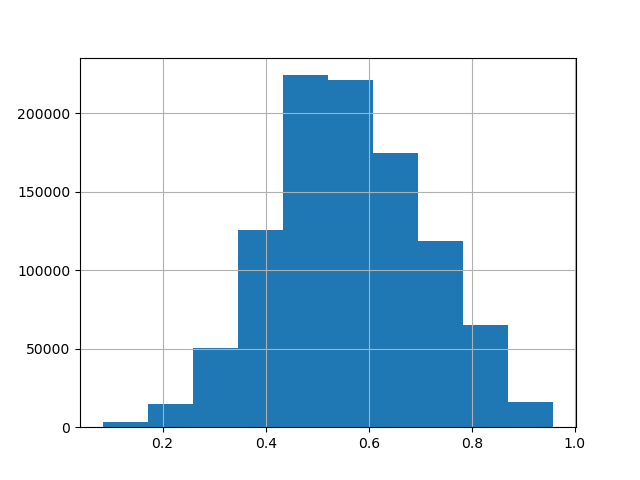

In [12]:
plt.figure()
clean_monthly_wu['simil_stat'].hist()


In [13]:
# add climate to the data
monthly_climate.rename(columns = {'year':'Year', 'month':'Month'}, inplace = True)
clean_monthly_wu = clean_monthly_wu.merge(monthly_climate, how = 'left', on = ['sys_id','Year', 'Month'])

In [14]:
# add some census data

In [15]:
clean_monthly_wu

,sys_id,Year,Month,monthly_fraction,simil_stat,monthly_wu,isswuds,etr,pr,pr_cumdev,tmmn,tmmx
0,AL0000002,2010,1.0,0.085277,0.500000,4588000.0,1,2.453693,4.948280,-27.996557,272.002545,284.398068
1,AL0000002,2010,2.0,0.079627,0.500000,4284000.0,1,2.701580,3.623699,-28.161687,272.587058,284.815636
2,AL0000002,2010,3.0,0.088158,0.500000,4743000.0,1,3.924579,3.384306,-28.566210,278.105888,290.924990
3,AL0000002,2010,4.0,0.093679,0.500000,5040000.0,1,6.128470,1.960925,-30.394115,283.965900,299.518964
4,AL0000002,2010,5.0,0.084701,0.500000,4557000.0,1,6.224974,5.416995,-28.765949,291.034474,303.053927
...,...,...,...,...,...,...,...,...,...,...,...,...
1012759,WV3303508,2019,10.0,0.072195,0.708333,1810000.0,0,3.818432,6.215626,-1.301853,280.536034,292.531981
1012760,WV3303508,2019,11.0,0.054286,0.708333,1361000.0,0,2.102379,2.112379,-2.240340,271.222943,280.649579
1012761,WV3303508,2019,11.0,0.054286,0.708333,1361000.0,0,2.102379,2.112379,-2.240340,271.222943,280.649579
1012762,WV3303508,2019,12.0,0.069722,0.708333,1748000.0,0,1.663677,3.401631,-1.889574,270.856395,279.546348


In [16]:
# add info from annual

clean_monthly_wu = clean_monthly_wu.merge(dataset[['sys_id', 'Year', 'LAT', 'LONG', 'KG_climate_zone', 'HUC2']], how = 'left', on = ['sys_id', 'Year'])

In [17]:
#add population
clean_monthly_wu = clean_monthly_wu.merge(master_pop, on=['sys_id', 'Year'], how = 'left')

In [18]:
clean_monthly_wu = clean_monthly_wu[clean_monthly_wu['monthly_fraction']>0]

In [25]:
clean_monthly_wu['simil_stat'].quantile(0.1)

0.4166666666666667

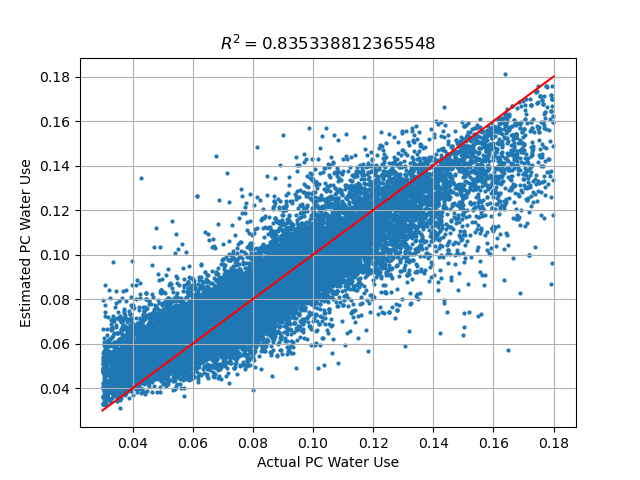

In [34]:
# Monthly Fraction model
columns_to_drop = ['simil_stat', 'isswuds', 'monthly_wu']
df = clean_monthly_wu.copy()
categorical_features = ['HUC2', 'KG_climate_zone' ]
ohc1 = MultiOneHotEncoder(catfeatures = categorical_features )
df = ohc1.transform(df)
df = df[df['monthly_fraction']<0.18]
df = df[df['monthly_fraction']>0.03]
df = df[df['simil_stat']>=0.7]
# mask1 = (df['LONG']>-80) &(df['simil_stat']>0.2) # east
# df = df[~mask1]
# mask1 = (df['LONG']<-80) &(df['simil_stat']<=0.75) # west
mask1 = df['LONG']<-90
df = df[~mask1]

sys_names = pd.DataFrame(df['sys_id'].unique())


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('monthly_fraction')


if 1:    
    X =df[features]
    del(X['sys_id'])
    y = df['monthly_fraction']
    #Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 123)
else: 
    #df = df[df['LONG']>-90]
    sys_names = pd.DataFrame(df['sys_id'].unique())
    trainsys = sys_names.sample(frac = 0.7, random_state = 123)
    testsys = sys_names.drop(trainsys.index)

    X_train = df[df['sys_id'].isin(trainsys[0])]
    y_train = X_train['monthly_fraction']
    del(X_train['monthly_fraction'])
    del(X_train['sys_id'])

    X_test = df[df['sys_id'].isin(testsys[0])]
    y_test = X_test['monthly_fraction']
    del(X_test['monthly_fraction'])
    del(X_test['sys_id'])
    

"""
colsample_bytree=0.8, learning_rate=0.20,
                                  max_depth=7, alpha=100,  n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.,
                                  seed = 123, reg_lambda=10, min_child_weight = 1, gamma = 10, max_delta_step = 0, 
                                  verbosity = 2
"""

gb = xgb.XGBRegressor(objective="reg:squarederror", tree_method = 'hist', n_estimators=600, learning_rate=0.06,
                      max_depth=10, subsample=0.85, colsample_bytree=0.9, verbosity=0,  rate_drop=0.1,  alpha=0, 
                      seed = 123,  skip_drop=0.5, gamma = 0)
gb.fit(X_train, y_train)
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)
plt.figure()
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()


In [23]:
df

,sys_id,Year,Month,monthly_fraction,etr,pr,pr_cumdev,tmmn,tmmx,LAT,...,KG_climate_zone_7.0,KG_climate_zone_8.0,KG_climate_zone_9.0,KG_climate_zone_14.0,KG_climate_zone_18.0,KG_climate_zone_19.0,KG_climate_zone_22.0,KG_climate_zone_25.0,KG_climate_zone_26.0,KG_climate_zone_27.0
0,AL0000002,2010,1.0,0.085277,2.453693,4.948280,-27.996557,272.002545,284.398068,32.432083,...,0,0,0,1,0,0,0,0,0,0
1,AL0000002,2010,2.0,0.079627,2.701580,3.623699,-28.161687,272.587058,284.815636,32.432083,...,0,0,0,1,0,0,0,0,0,0
2,AL0000002,2010,3.0,0.088158,3.924579,3.384306,-28.566210,278.105888,290.924990,32.432083,...,0,0,0,1,0,0,0,0,0,0
3,AL0000002,2010,4.0,0.093679,6.128470,1.960925,-30.394115,283.965900,299.518964,32.432083,...,0,0,0,1,0,0,0,0,0,0
4,AL0000002,2010,5.0,0.084701,6.224974,5.416995,-28.765949,291.034474,303.053927,32.432083,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212091,WV3303508,2019,11.0,0.054286,2.102379,2.112379,-2.240340,271.222943,280.649579,NaN,...,0,0,0,0,0,0,0,0,0,0
1212092,WV3303508,2019,12.0,0.069722,1.663677,3.401631,-1.889574,270.856395,279.546348,NaN,...,0,0,0,0,0,0,0,0,0,0
1212093,WV3303508,2019,12.0,0.069722,1.663677,3.401631,-1.889574,270.856395,279.546348,NaN,...,0,0,0,0,0,0,0,0,0,0
1212094,WV3303508,2019,12.0,0.069722,1.663677,3.401631,-1.889574,270.856395,279.546348,NaN,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Gain', ylabel='Features'>

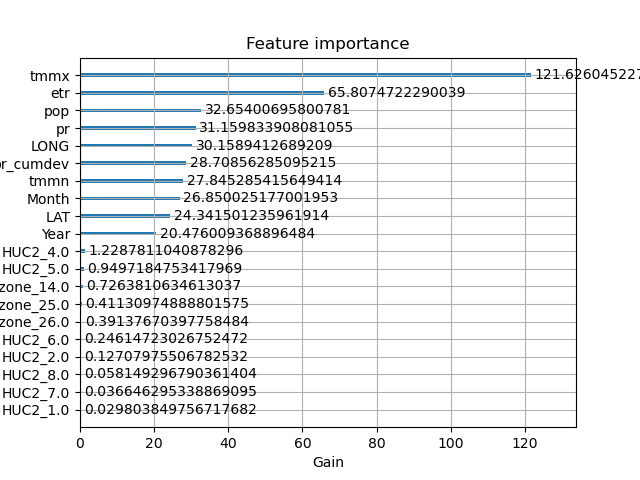

In [36]:
plot_importance(gb, xlabel='Gain', importance_type='total_gain', max_num_features = 20)

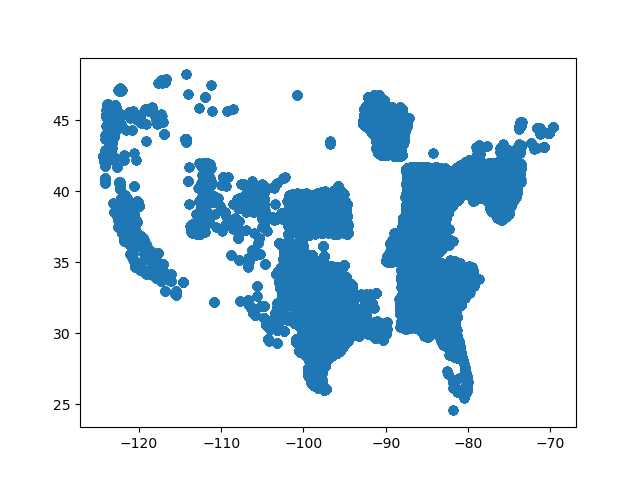

In [27]:
plt.figure()
plt.scatter(df['LONG'], df['LAT'])

In [35]:
df

,sys_id,Year,Month,monthly_fraction,etr,pr,pr_cumdev,tmmn,tmmx,LAT,...,KG_climate_zone_7.0,KG_climate_zone_8.0,KG_climate_zone_9.0,KG_climate_zone_14.0,KG_climate_zone_18.0,KG_climate_zone_19.0,KG_climate_zone_22.0,KG_climate_zone_25.0,KG_climate_zone_26.0,KG_climate_zone_27.0
96,AL0000038,2010,1.0,0.079811,3.302783,5.276736,-26.271368,277.104700,286.590303,30.273008,...,0,0,0,1,0,0,0,0,0,0
97,AL0000038,2010,2.0,0.064487,3.432945,4.298449,-26.472045,277.331733,286.844668,30.273008,...,0,0,0,1,0,0,0,0,0,0
98,AL0000038,2010,3.0,0.082692,4.822698,5.356314,-25.614857,282.276212,291.978548,30.273008,...,0,0,0,1,0,0,0,0,0,0
99,AL0000038,2010,4.0,0.098298,6.228188,1.763925,-28.350058,289.304394,298.027946,30.273008,...,0,0,0,1,0,0,0,0,0,0
100,AL0000038,2010,5.0,0.105055,7.079430,7.613676,-25.235508,295.417254,302.484715,30.273008,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212091,WV3303508,2019,11.0,0.054286,2.102379,2.112379,-2.240340,271.222943,280.649579,NaN,...,0,0,0,0,0,0,0,0,0,0
1212092,WV3303508,2019,12.0,0.069722,1.663677,3.401631,-1.889574,270.856395,279.546348,NaN,...,0,0,0,0,0,0,0,0,0,0
1212093,WV3303508,2019,12.0,0.069722,1.663677,3.401631,-1.889574,270.856395,279.546348,NaN,...,0,0,0,0,0,0,0,0,0,0
1212094,WV3303508,2019,12.0,0.069722,1.663677,3.401631,-1.889574,270.856395,279.546348,NaN,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
columns_to_drop = ['sys_id', 'simil_stat']
df = clean_monthly_wu.copy()
df = df[df['monthly_fraction']<0.2]
df = df[df['monthly_fraction']>0.03]
df['simil_stat'].unique()

In [ ]:
len(df)

In [ ]:
plot_importance(gb, xlabel='Gain', importance_type='total_gain', max_num_features = 20)

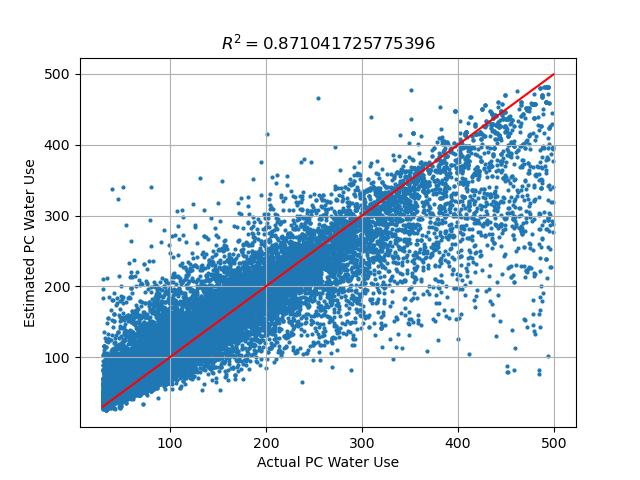

In [41]:
## per capita
columns_to_drop = ['simil_stat', 'isswuds', 'monthly_fraction', 'monthly_wu']
df = clean_monthly_wu.copy()
df['pc'] = df['monthly_wu']/df['pop']/30.25 
categorical_features = ['HUC2', 'KG_climate_zone' ]
ohc1 = MultiOneHotEncoder(catfeatures = categorical_features )
df = ohc1.transform(df)
df = df[df['pc']<=500]
df = df[df['pc']>=30]
df = df[df['simil_stat']>0.75]

sys_names = pd.DataFrame(df['sys_id'].unique())


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')


if 1:    
    X =df[features]
    del(X['sys_id'])
    y = df['pc']
    #Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 123)
else: 
    
    sys_names = pd.DataFrame(df['sys_id'].unique())
    trainsys = sys_names.sample(frac = 0.7)
    testsys = sys_names.drop(trainsys.index)

    X_train = df[df['sys_id'].isin(trainsys[0])]
    y_train = X_train['pc']
    del(X_train['pc'])
    del(X_train['sys_id'])

    X_test = df[df['sys_id'].isin(testsys[0])]
    y_test = X_test['pc']
    del(X_test['pc'])
    del(X_test['sys_id'])
    

"""
colsample_bytree=0.8, learning_rate=0.20,
                                  max_depth=7, alpha=100,  n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.,
                                  seed = 123, reg_lambda=10, min_child_weight = 1, gamma = 10, max_delta_step = 0, 
                                  verbosity = 2
"""

gb = xgb.XGBRegressor(objective="reg:squarederror", tree_method = 'hist', n_estimators=600, learning_rate=0.07,
                      max_depth=7, subsample=1, colsample_bytree=1, verbosity=0,  rate_drop=0.1,  alpha=0, 
                      seed = 123,  skip_drop=0.5, gamma = 0)
gb.fit(X_train, y_train)
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)
plt.figure()
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Gain', ylabel='Features'>

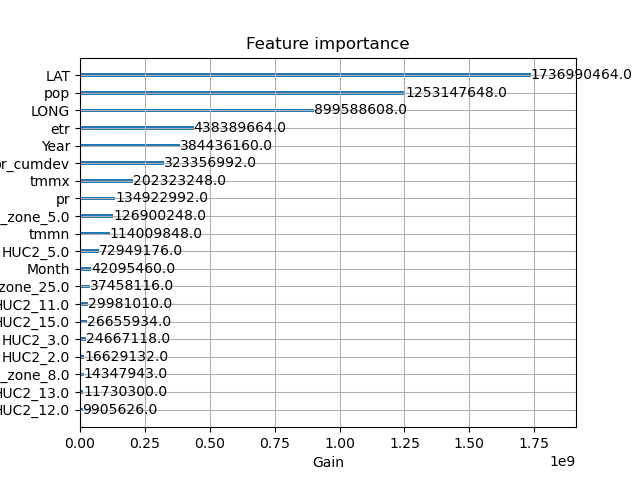

In [42]:
plot_importance(gb, xlabel='Gain', importance_type='total_gain', max_num_features = 20)

In [ ]:
df